# [Sartorius - Cell Instance Segmentation](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Detect single neuronal cells in microscopy images

![](https://storage.googleapis.com/kaggle-competitions/kaggle/30201/logos/header.png?t=2021-09-03-15-27-46)

# 📒 Notebooks:
* Train: [Sartorius: MMDetection [Train]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-train)
* Infer: [Sartorius: MMDetection [Infer]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer)
* Data:  [Sartorius: COCO Data](https://www.kaggle.com/awsaf49/sartorius-coco-data)

# Please Upvote If you find this notebook Useful :)

# 🛠 Install Libraries

In [ ]:
# dependencies
!pip install -q /kaggle/input/mmdet-lib-ds-v2/torch-1.7.0%2Bcu110-cp37-cp37m-linux_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/torchvision-0.8.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/yapf-0.32.0-py2.py3-none-any.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/pycocotools-2.0.3/pycocotools-2.0.3.tar
!pip install -q /kaggle/input/mmdet-lib-ds-v2/mmcv_full-1.4.2-cp37-cp37m-manylinux1_x86_64.whl
!pip install -q /kaggle/input/mmdet-lib-ds-v2/addict-2.4.0-py3-none-any.whl


#wandb
!pip install -qU wandb

# 📚 Import Libraries

In [ ]:
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import wandb
from PIL import Image
import gc

from glob import glob
import matplotlib.pyplot as plt

# ⭐ WandB
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width=600>

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of W&B:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.


In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

# 📖 Meta Data

`tain.csv` - IDs and masks for all training objects. None of this metadata is provided for the test set.
* `id` - unique identifier for object
* `annotation` - run length encoded pixels for the identified neuronal cell
* `width` - source image width
* `height` - source image height
* `cell_type` - the cell line
* `plate_time` - time plate was created
* `sample_date` - date sample was created
* `sample_id` - sample identifier
* `elapsed_timedelta` - time since first image taken of sample


In [ ]:
ROOT = '../input/sartorius-cell-instance-segmentation'
DATA_DIR = '../input/sartorius-coco-dataset'
config = 'configs/sartorius/custom_config.py'


# Train Data
df = pd.read_csv(f'{ROOT}/train.csv')
df['image_path'] = ROOT + '/train/' + df['id'] + '.png'
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
df = tmp_df.copy()
df['label']   = df.cell_type.map({v:k for k, v in enumerate(df.cell_type.unique())})
df['num_ins'] = df.annotation.map(lambda x: len(x))
display(df.head(2))

# 🌈 Visualization


In [ ]:
annFile = f'{DATA_DIR}/annotations_train.json'
coco    = COCO(annFile)
imgIds  = coco.getImgIds()

tmp_df = df.query("num_ins<=30 and num_ins>=15").head(2)
_,axs = plt.subplots(len(tmp_df),2,figsize=(40,15 * len(tmp_df)))
for (_, row), ax in zip(tmp_df.iterrows(), axs):
    img = cv2.imread(DATA_DIR+f'/train2017/{row.id}.png')
    img_img = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)).apply(img[...,0])
    annIds  = coco.getAnnIds(imgIds=[row.id])
    anns    = coco.loadAnns(annIds)
    ax[0].imshow(img)
    ax[1].imshow(img)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)
plt.tight_layout()
plt.show()
del coco; gc.collect()

# 📦 MMDetetection
<div align=center><img src="https://raw.githubusercontent.com/open-mmlab/mmdetection/master/resources/mmdet-logo.png" width=500></div>

Here are some cool facts about **MMDet**,
* It comes with bunch of sota models. You may get tired trying them out ;)
* Easy to comstomize and Deploy.
* It has built-in **wandb** integration. So, we can easily track our training.
* Error/Result Analysis is easier.

In [ ]:
# mmdet
!rm -r /kaggle/working/mmdetection
!cp -r /kaggle/input/mmdet-repo-ds /kaggle/working/mmdetection
%cd mmdetection
!pip install -q -e .

# ⚙️ Configuration
> You can tune following parameters for better result. 

* **Num Classes** 
* **Score-Theshold**
* **IoU**
* **Wandb**
```
dict(type='WandbLoggerHook', # this is where magic happens ;)
     init_kwargs=dict(project='sartorius',
                      name=f'mask_rcnn_r50',
                      config={'config':mask_rcnn_r50_fpn_1x_coco,
                      'comment':'baseline01',},
                      entity=None)) # this is where magic happens
```
* **Augmentation** 
    * **Flip**
    * **Multi-Scale**
    * **PhotoMetricDistortion**
* **Batch Size**

In [ ]:
!mkdir -p configs/sartorius

In [ ]:
%%writefile configs/sartorius/custom_config.py

# model settings
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=1,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))),
    # model training and testing settings
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            mask_size=28,
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100,
            mask_thr_binary=0.5)))

# dataset settings
dataset_type = 'CocoDataset'
classes = ('cell',) # Added
data_root = '/kaggle/input/sartorius-coco-dataset/' # Modified
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize',
         img_scale=(768, 768), # [(1280, 1280), (1152, 1152), (1024, 1024)],
#          multiscale_mode='value',
         keep_ratio=True),
    dict(type='RandomFlip', direction=['horizontal', 'vertical'], flip_ratio=0.5), # augmentation starts
    dict(type='PhotoMetricDistortion',
         brightness_delta=32, contrast_range=(0.5, 1.5),
         saturation_range=(0.5, 1.5), hue_delta=18),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(768, 768), # (1280, 1280),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=12, # BATCH_SIZE
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_train.json', # Modified
        img_prefix=data_root + 'train2017/', # Modified
        classes=classes, # Added
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_valid.json', # Modified
        img_prefix=data_root + 'valid2017/', # Modified
        classes=classes, # Added
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations_valid.json', # Modified
        img_prefix=data_root + 'valid2017/', # Modified
        classes=classes, # Added
        pipeline=test_pipeline))
evaluation = dict(interval=1,
                  metric=['bbox','segm'], # bbox, segm
                  save_best='segm_mAP')



# optimizer
optimizer = dict(type='SGD', lr=0.02, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])
runner = dict(type='EpochBasedRunner', max_epochs=15)

# default_runtime
checkpoint_config = dict(interval=-1)
# yapf:disable
log_config = dict(
    interval=10,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(type='WandbLoggerHook', # wandb logger
             init_kwargs=dict(project='sartorius-public',
                              name=f'mask_rcnn-resnet50-768x768-fold0',
                              config={'config':'mask_rcnn_r50_fpn_1x_coco',
                                      'exp_name':'mask_rcnn-resnet50-768x768',
                                      'comment':'baseline',
                                      'batch_size':12,
                                      'lr':0.020
                                     },
                              group='exp_name',
                              entity=None))
        # dict(type='TensorboardLoggerHook')
    ])
# yapf:enable
custom_hooks = [dict(type='NumClassCheckHook')]

dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth'
resume_from = None
workflow = [('train', 1)]

# 🚅 Training

In [ ]:
!python tools/train.py {config}

In [ ]:
ls work_dirs/custom_config

# ✨ Overview
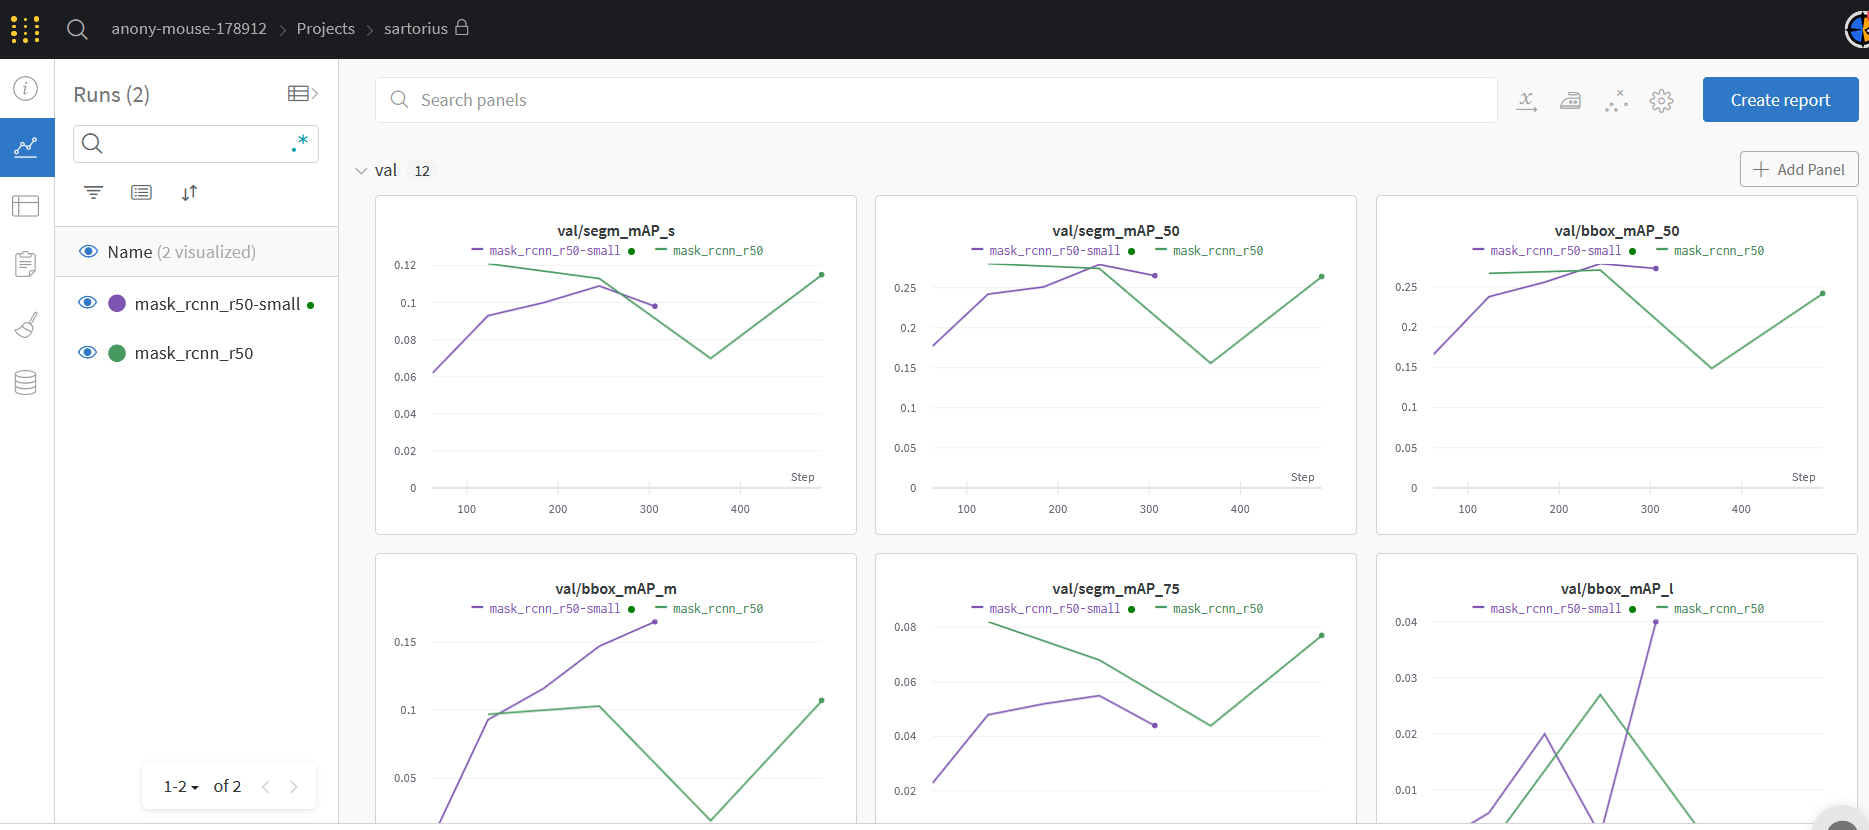

# 🔎 Result Analysis

## Best Checkpoint

In [ ]:
ckpt  = glob('work_dirs/custom_config/best_segm_mAP_epoch_*.pth')[0]
ckpt

## Test Model

In [ ]:
!python tools/test.py {config} {ckpt} --eval segm --out /kaggle/working/result.pkl

## Analyze

In [ ]:
!python tools/analysis_tools/analyze_results.py \
       {config} \
       /kaggle/working/result.pkl \
       /kaggle/working/result\
       --show-score-thr 0.40

## Utils

In [ ]:
def plot_batch(paths,row = 3, col = 2, scale=1.5):
    plt.figure(figsize=(col*7.04*scale, row*5.2*scale))
    for i, path in enumerate(paths[:row*col]):
        plt.subplot(row, col, i+1)
        img = cv2.imread(path)[...,::-1]
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

# 👍 Good Ones

In [ ]:
good_paths = glob('/kaggle/working/result/good/*')
plot_batch(good_paths)

# 👎 Bad Ones

In [ ]:
bad_paths = glob('/kaggle/working/result/bad/*')
plot_batch(bad_paths)

# ✂️ Remove Files

In [ ]:
!cp -r work_dirs /kaggle/working
%cd /kaggle/working
!rm -r /kaggle/working/mmdetection

# 💡 Reference
* [mmdetection for segmentation [training]](https://www.kaggle.com/its7171/mmdetection-for-segmentation-training) by @its7171
* [Sartorius Segmentation - Mask Dataset](https://www.kaggle.com/dschettler8845/sartorius-segmentation-mask-dataset) by @dschettler8845

# Please Upvote If you find this notebook Useful :)